In [ ]:
from torchvision import transforms
from PIL import Image
import os
from torchvision.transforms import v2
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
import csv

from tqdm import tqdm

import torch
import torchvision.transforms as T
import random
from sklearn.metrics import f1_score, recall_score
import glob

from skimage.feature import peak_local_max
from skimage import img_as_float
from scipy import ndimage as ndi

from segment_anything import sam_model_registry, SamPredictor

In [2]:
# Path to local clone of the repo
REPO_DIR = "dinov3"

# Path to the downloaded checkpoint
CHECKPOINT_PATH = "dinov3_vits16_pretrain_lvd1689m-08c60483.pth"

# Load the model
model = torch.hub.load(REPO_DIR, 'dinov3_vits16', source='local', weights=CHECKPOINT_PATH)

model.eval()
print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
#From the meta github page:
def make_transform(resize_size: int = 256):
    to_tensor = v2.ToImage()
    resize = v2.Resize((resize_size, resize_size), antialias=True)
    to_float = v2.ToDtype(torch.float32, scale=True)
    normalize = v2.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )
    return v2.Compose([to_tensor, resize, to_float, normalize])

pre_process = make_transform(resize_size = 256) #Could change size if we want


# SAM functions
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   


# A class structure with metods that can calculate anomaly maps/heatmaps and scores.
class Calculate_Anomaly_And_Mask:
    """
    Does anomaly score calculation, and mask segnemtation(ish)
    Inputs:
    Model - Whatever pretrained torch model that we are currently using (only really works for DinoV3 so far.)
    Training_Data - All the images that we use for "training" which in this case is just feature extraction.
    Test_Data - All the pictures which are different/anomalous in some respect, and also the normal pictures which we can compare with.
    """
    
    def __init__(self, model, TrainData, TestData, optional_param=None, rescale_training=False, rescale_test = False, rescale_factor=1.0):
        """
        Can also print some segmentation maps for visual inspection.
        """
        # Instance variables
        self.model = model
        self.TrainData = TrainData
        self.TestData = TestData
        self.optional_param = optional_param # we never did use these...
        
        # Computed/internal variables
        self._private_var = None
        self.result = None
        self.G_cls_Tokens_Train = None
        self.G_cls_Tokens_Test = None
        self.P_cls_Tokens_Test = None
        self.N = None
        self.similarity_mode = "cosine"
        self.Anomaly_Scores = None
        # user settings
        self.rescale_training = rescale_training
        self.rescale_factor = rescale_factor
        self.rescale_test = rescale_test
        
    def Get_cls_Tokens_Global(self, Data):
        """
        This metod uses the model to extract global cls tokens.
        
        Parameters:
        -----------
        Data : PIL loaded Images in a list format, where we can loop over and extract tokens (and save them in another list ;P)
            
            
        Returns:
        --------
        List of tensors with cls_tokens.
        """
        cls_tokens = [] #Preallocate a list

        self.model.eval()
        with torch.no_grad():
            for img in Data:
                #Preprocess the image
                img_tensor = pre_process(img).unsqueeze(0)
                #Get features from the model
                features_dict = self.model.forward_features(img_tensor)
                #Get global cls features
                cls = features_dict["x_norm_clstoken"]  # shape [1, C]
                #Append to the list.
                cls_tokens.append(cls.squeeze(0))  # shape [C]
        return cls_tokens
    
    def Get_cls_Tokens_Patch(self, Data):
        """
        Here we get the patch level cls tokens from the images, and agian save them in a list. Each patch is 16x16.

        """
        Patch_Tokens = []
        self.model.eval()
        with torch.no_grad():
            for img in Data:
                #Preprocess the image
                img_tensor = pre_process(img).unsqueeze(0)
                #Get features from the model
                features_dict = self.model.forward_features(img_tensor)
                #Get global cls patch features
                Patch = features_dict["x_norm_patchtokens"]  # shape [1, C]
                #Append to the list.
                Patch_Tokens.append(Patch.squeeze(0))  # → shape [C]
        # print(f'Patch token size: {np.array(Patch_Tokens).shape}')

        return Patch_Tokens
    
    def Get_Consine_Simlilarity(self, Patch_cls, Global_cls):
        """
        This function calculates the consine similarity between global cls tokens from an image, and the patch level embeddings from an image.
        """
        sim = F.cosine_similarity(Patch_cls, Global_cls.unsqueeze(0), dim=-1)

        return sim
    
    def Get_Cosine_Simlilarity_pp(self, Patch_cls1, Patch_cls2):
        """
        This function calculates the consine similarity between patch level features between two images.
        """
        sim = F.cosine_similarity(Patch_cls1, Patch_cls2, dim = -1)

        return sim
        

    def compute_similarity(self, x, y): #Default is cosine. This is just a more general version hehe. #Also, the rest dont have good results, and meta also has their demo with cosine.
        mode = self.similarity_mode
        if mode == "cosine":
            return F.cosine_similarity(x, y, dim=-1)
        elif mode == "dot":
            return (x * y).sum(dim=-1)
        elif mode == "l2":
            return torch.norm(x - y, dim=-1)
        elif mode == "mahalanobis":
            return self.compute_mahalanobis(x, y)
        else:
            raise ValueError(f"Unknown similarity type: {mode}")

    def UpsampleImage(self, Image):
        # Upsample from 16×16 to 256×256 using PyTorch
        heatmap_up = F.interpolate(
            Image.unsqueeze(0).unsqueeze(0),  
            size=(256, 256),
            mode="bicubic",
            align_corners=False
        )[0, 0].cpu().numpy()
        return heatmap_up
    
    def UpsampleImage_By_Amount(self, img_tensor, amount):
        """
        Upsamples an image by an amount, i had to use chatgpt for debugging a lot here.
        """
        if img_tensor.ndim == 3: 
            img_tensor = img_tensor.permute(2,0,1)  # → (C,H,W)

        c, h, w = (img_tensor.shape if img_tensor.ndim == 3 
                else (1,) + tuple(img_tensor.shape))

        new_h = int(h * amount)
        new_w = int(w * amount)

        img_tensor = img_tensor.unsqueeze(0)  # → (1,C,H,W)

        out = F.interpolate(
            img_tensor,
            size=(new_h, new_w),
            mode="bicubic",
            align_corners=False
        )[0]  # → (C, new_h, new_w)

        if c == 1:
            out = out[0]
        else:
            out = out.permute(1,2,0)  # → (new_h,new_w,3)

        return out.cpu().numpy()
    

    def Rescale_Training_Data(self, scale_factor: float):
        """
        Rescales all training images by a user-specified factor.
        Uses UpsampleImage_By_Amount to do the resizing.

        scale_factor > 1  → upsample
        scale_factor < 1  → downsample
        """

        if scale_factor == 1.0:
            # Nothing to do
            return

        # print(f"[INFO] Rescaling all training images by factor {scale_factor} ...")

        new_train = []
        for img in self.TrainData:
            arr = np.asarray(img)                # PIL -> numpy array
            tensor = torch.from_numpy(arr)
            # Convert PIL → tensor (C,H,W) or (H,W) depending on your UpsampleImage_By_Amount
            img_tensor = torch.tensor(tensor, dtype=torch.float32)

            # UpsampleImage_By_Amount works per-image
            new_img = self.UpsampleImage_By_Amount(img_tensor, scale_factor)


            # Convert back to PIL & append
            resized_pil = Image.fromarray(new_img.astype(np.uint8))
            new_train.append(resized_pil)

        self.TrainData = new_train

        # print(f"[INFO] Training set rescaled: {len(self.TrainData)} images updated.")

    def Rescale_Test_Data(self, scale_factor: float):
        """
        Rescales all training images by a user-specified factor.
        Uses UpsampleImage_By_Amount to do the resizing.

        scale_factor > 1  → upsample
        scale_factor < 1  → downsample
        """

        if scale_factor == 1.0:
            # Nothing to do
            return

        # print(f"[INFO] Rescaling all test images by factor {scale_factor} ...")
        new_test = []
        for img in self.TestData:

            arr = np.asarray(img)                # PIL -> numpy array
            tensor = torch.from_numpy(arr)
            # Convert PIL → tensor (C,H,W) or (H,W) depending on your UpsampleImage_By_Amount
            img_tensor = torch.tensor(tensor, dtype=torch.float32)

            # UpsampleImage_By_Amount works per-image
            new_img = self.UpsampleImage_By_Amount(img_tensor, scale_factor)


            # Convert back to PIL & append
            resized_pil = Image.fromarray(new_img.astype(np.uint8))
            new_test.append(resized_pil)

        self.TestData = new_test

        # print(f"[INFO] Test set rescaled: {len(self.TestData)} images updated.")


    def Compute_Anomaly_Mask7(self): #Now, we make it possible to resize/rescale/interpolate the images before we do feature extraction. The reason for 7, is because 7 other vesions came before this one.
        """
        This function computes the anomaly mask. First we get the self similarity, that is, the global cls token similarity with each patch cls token of the test images. 
        Next the similarity between global cls tokens from the train set (bottels we know are intact) and patch tokens from the test set (might be broken), is computed. 
        At last we subtract the self similarity from the similarity between broken and intact, to get the mask.
        
        """
            # Optional data rescaling, but be careful, if done in a loop where rescale_training==TRUE, then we will rescale training data on each iteration, unless redefined.
        if self.rescale_training:
            self.Rescale_Training_Data(self.rescale_factor)

        if self.rescale_test:
            self.Rescale_Test_Data(self.rescale_factor)

        # Get and save the global CLS tokens. 
        self.G_cls_Tokens_Train = self.Get_cls_Tokens_Patch(self.TrainData)
        self.G_cls_Tokens_Test = self.Get_cls_Tokens_Global(self.TestData) #Patch does not make too much sense here. 
        # We dont really use global tokenes anymore though. We could change it, but who cares now.
        # Get the 16x16 patch tokens from the test images.
        self.P_cls_Tokens_Test = self.Get_cls_Tokens_Patch(self.TestData)

        # Now, we make a list, and save all the consine similarities between intact and test images (and take the mean).
        Similarities_Test_to_Train = []   #will store one entry per test image

        for test_patch in self.P_cls_Tokens_Test:     # loop over each test image
            sims_for_this_test = []                    # store similarities to all train images
            
            for train_global in self.G_cls_Tokens_Train:   # loop over each train image
                # Use the function from before to calculate.
                sim = self.compute_similarity(test_patch, train_global)
                # Reshape to 16x16 make it np, and append.
                sims_for_this_test.append(sim.reshape(16,16).cpu().numpy()) #Maybe we could use CUDA here for a speedup?
            
            # compute mean similarity test -> all train
            # Basically convert to np, and take the mean over the 1'rd dimension.
            # print(f'sims_for_this_test size {np.array(sims_for_this_test).shape}')
            # mean_sim = np.mean(np.stack(sims_for_this_test), axis=0)  # shape [16,16]
            # print(f'mean_sim_size {mean_sim.shape}')
            # Similarities_Test_to_Train.append(mean_sim)

            # Changed this so that we only choose the top 5 images that are similar
            sims = np.stack(sims_for_this_test, axis=0)   # shape [209, 16,16]
            # For each pixel location: sort similarities of all train images

            #Also try this one later:
            # mean_sim = np.max(sims, axis=0)
            # mean_sim = np.median(sims, axis=0)
            # and pick top K most similar bottles (we used bottels as the first examples)
            top_k = 5
            # Sort the list
            sims_sorted = np.sort(sims, axis=0)
            # take K largest similarities
            top_k_sims = sims_sorted[-top_k:, :, :]  

            mean_sim = np.mean(top_k_sims, axis=0)
            # print(f'mean_sim_size {mean_sim.shape}')
            Similarities_Test_to_Train.append(mean_sim)

        

        # Compute self-similarity for all test images (not really used anymore but whatever.)
        Self_Similarity_Test = []
        
        for i, test_patch in enumerate(self.P_cls_Tokens_Test):
            global_test = self.G_cls_Tokens_Test[i]  # corresponding global CLS tokens
            sim = self.compute_similarity(test_patch, global_test) #Other similarity measures implemented
            sim = sim.reshape(16, 16)               # reshape to 16x16 patch grid
            Self_Similarity_Test.append(sim.cpu().numpy())  # convert to numpy

        # Now we upsample the images.
        # First the test_train similarityies.
        # Convert to numpy array and upsample
        Upsampled_Test_to_Train = [] #This one can save the heatmaps
        Upsampled_Test_to_Train_Scoring = [] #This one for scores.
        for img in Similarities_Test_to_Train:
            # Upsample
            up_img = self.UpsampleImage(torch.tensor(img, dtype=torch.float32))
            # Normalize to [0, 1] for the heatmaps
            heatmap_norm = 1-((up_img - up_img.min()) / (up_img.max() - up_img.min()))
            #Save
            Upsampled_Test_to_Train.append(heatmap_norm)
            Upsampled_Test_to_Train_Scoring.append(1-up_img)
            
        Upsampled_Test_to_Train = np.array(Upsampled_Test_to_Train)  # shape [num_test, 256, 256]
        Upsampled_Test_to_Train_Scoring = np.array(Upsampled_Test_to_Train_Scoring)
        #Now the self similarity.
        Upsampled_Self_Similarity = []
        Upsampled_Self_Similarity_Scoreing = []
        #Also upsample, normalize and calculate scores.
        for img in Self_Similarity_Test:
            up_img = self.UpsampleImage(torch.tensor(img, dtype=torch.float32)) # convert to tensor
            heatmap_norm = (up_img - up_img.min()) / (up_img.max() - up_img.min())
            Upsampled_Self_Similarity.append(heatmap_norm)
            Upsampled_Self_Similarity_Scoreing.append(up_img)

        # print("Train CLS tokens:", len(self.G_cls_Tokens_Train))
        # print("Test CLS tokens:", len(self.G_cls_Tokens_Test))
        # print("Patch tokens test:", len(self.P_cls_Tokens_Test))
        # Convert to numpy array (num_test_images, 256, 256)
        Upsampled_Self_Similarity = np.array(Upsampled_Self_Similarity)
        Upsampled_Self_Similarity_Scoreing = np.array(Upsampled_Self_Similarity_Scoreing)
        # And now we can remove the self similrairt from the similarity between test and intact, to get a somewhat approximate mask.

        # Notice that self similarity is no longer in use, before this version we would subtract it.
        Anomaly_Scores = Upsampled_Test_to_Train_Scoring

        # print(Anomaly_Scores.shape)
        # print(Anomaly_Scores.reshape(Anomaly_Scores.shape[0], -1).shape)
        
        # Calculate some different Anomaly scores.
        mean_scores = Anomaly_Scores.reshape(Anomaly_Scores.shape[0], -1).mean(axis=1)
        max_scores = Anomaly_Scores.reshape(Anomaly_Scores.shape[0], -1).max(axis=1)
        percentile_scores = np.percentile(Anomaly_Scores.reshape(Anomaly_Scores.shape[0], -1), 95, axis=1)

        self.Anomaly_Scores = np.array([mean_scores, max_scores, percentile_scores]) #Didnt wanna change the use, so i save them inside the object instead.

        # print(Anomaly_Scores.max())
        # The areas where test patches are less like themselves than like train should stand out
        #Anomaly_Maps = (Upsampled_Self_Similarity - Upsampled_Test_to_Train)
        Anomaly_Maps = Upsampled_Test_to_Train
        #Normalize agian:
        #Anomaly_Maps = (Anomaly_Maps - Anomaly_Maps.min())/(Anomaly_Maps.max()-Anomaly_Maps.min())

        return Anomaly_Maps

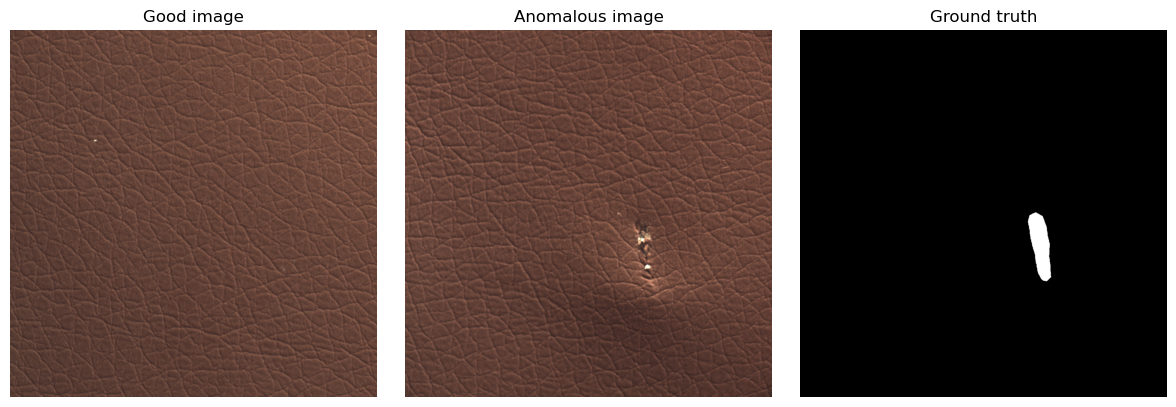

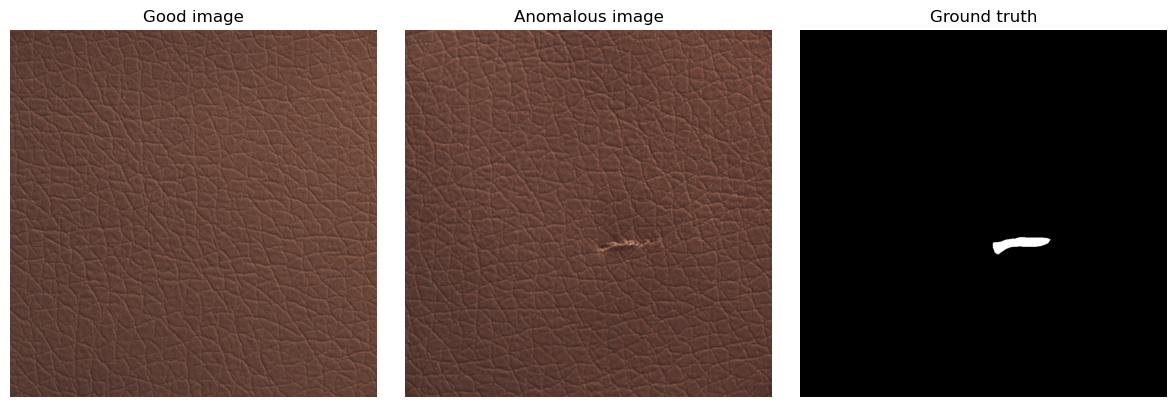

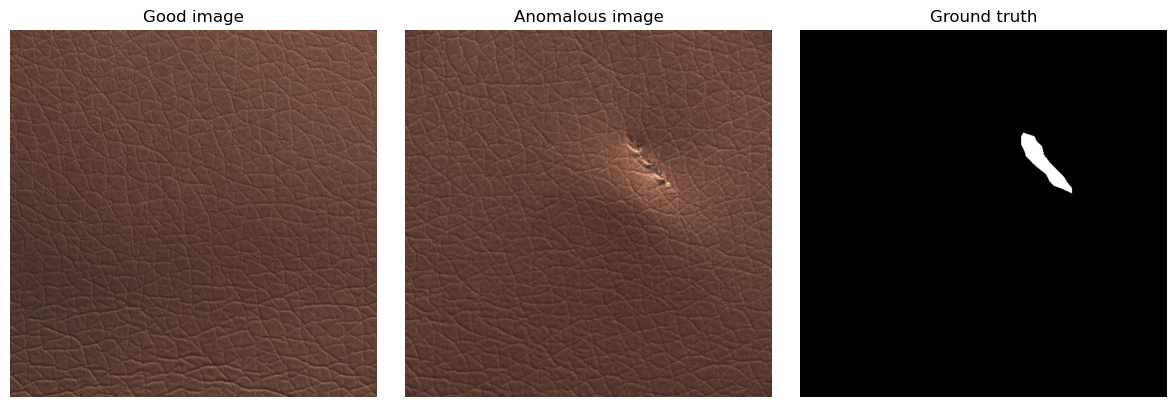

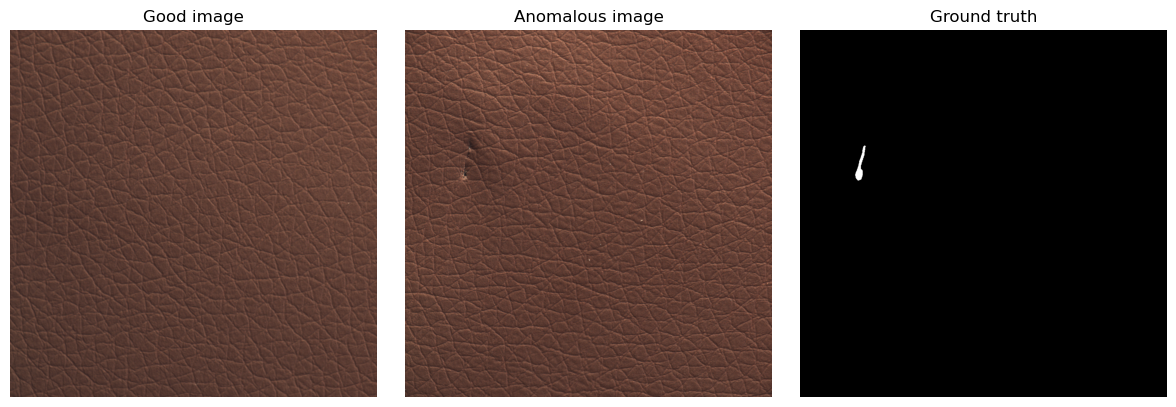

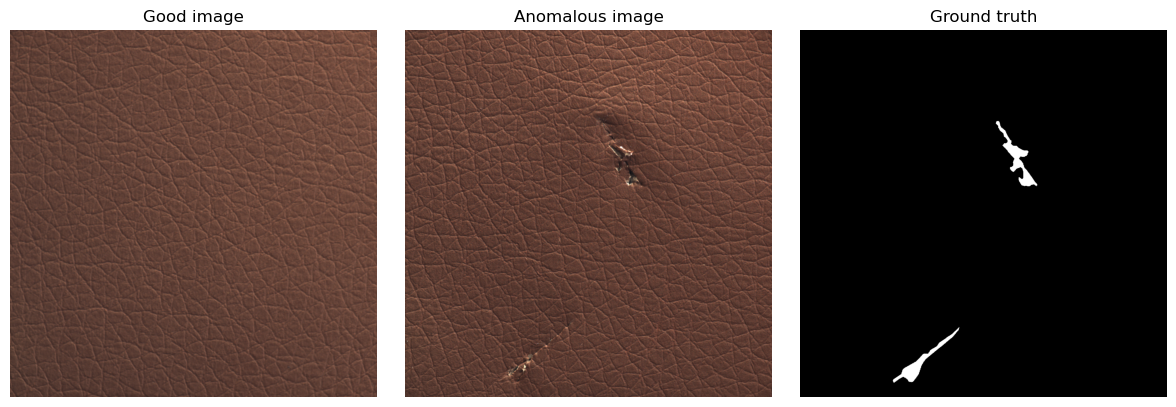

In [ ]:
# Getting sample images of the dataset

DATA_DIR = "mvtec_anomaly_detection/"

category = "leather"
anomaly = "cut"
use_test_image_num = False # set to True to set num_to_show equal to all the test images 
num_to_show = 1

show_images = True

# Loading images
train_folder = DATA_DIR + f"{category}/train/good"
test_folder = DATA_DIR + f"{category}/test/{anomaly}"
ground_truth_folder = DATA_DIR + f"{category}/ground_truth/{anomaly}"

train_image_paths = sorted(glob.glob(train_folder + "/*.png"))
test_image_paths = sorted(glob.glob(test_folder + "/*.png"))
ground_truth_paths = sorted(glob.glob(ground_truth_folder + "/*.png"))

Train_Images = [Image.open(p).convert("RGB") for p in train_image_paths]
Test_Images = [Image.open(p).convert("RGB") for p in test_image_paths]
Truth_Images = [Image.open(p).convert("RGB") for p in ground_truth_paths]


# Visualizing some random test images with their anomaly maps
if (use_test_image_num==True):
    num_to_show = len(Test_Images)
indices = random.sample(range(len(Test_Images)), num_to_show)



for i, idx in enumerate(indices): #Change this if we want random ones, but i think we should calculate everything everytime to get a true average dice score preformance.
    if (anomaly!="good"):
        ground_truth_path = DATA_DIR + f"{category}/ground_truth/{anomaly}/{str(idx).zfill(3)}_mask.png"
        ground_truth = cv2.imread(ground_truth_path)

        # Resizing ground truth to 256 x 256
        ground_truth = cv2.resize(ground_truth, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)[:, :, 1]
        ground_truth = (ground_truth - ground_truth.min()) / (ground_truth.max() - ground_truth.min())
        ground_truth = ground_truth.astype(int)
    else:
        ground_truth = np.zeros((256, 256))

    if (show_images==False):
        pass

    else:
        plt.figure(figsize=(12, 4))
        train_image = Train_Images[idx]
        test_img = Test_Images[idx]
        ground_truth_image = Truth_Images[idx]

        # Show test image
        plt.subplot(1, 3, 1)
        plt.imshow(train_image)
        plt.title(f"Good image")
        plt.axis('off')

        # Show anomalous map
        plt.subplot(1, 3, 2)
        plt.imshow(test_img)
        plt.title(f"Anomalous image")
        plt.axis('off')

        # Show ground truth
        plt.subplot(1, 3, 3)
        plt.imshow(ground_truth_image, cmap='binary')
        plt.title(f"Ground truth")
        plt.axis('off')

        plt.tight_layout()
        plt.show()


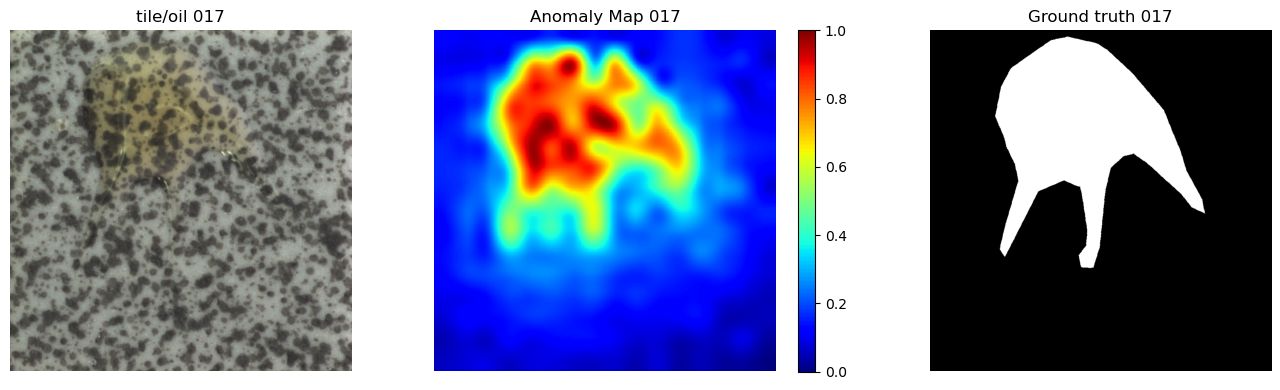

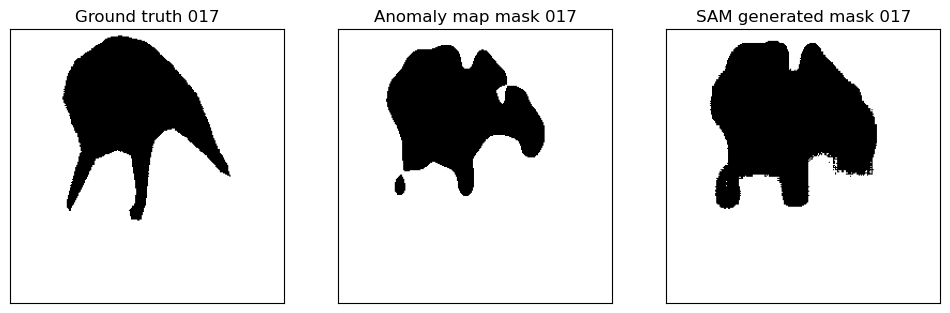

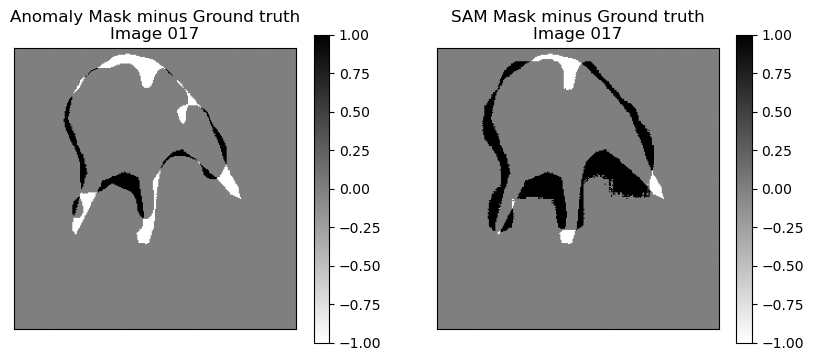

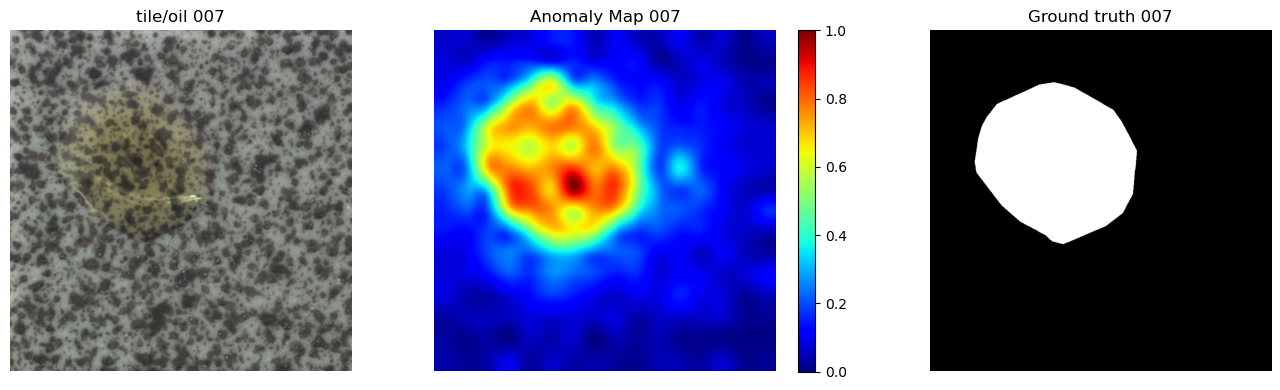

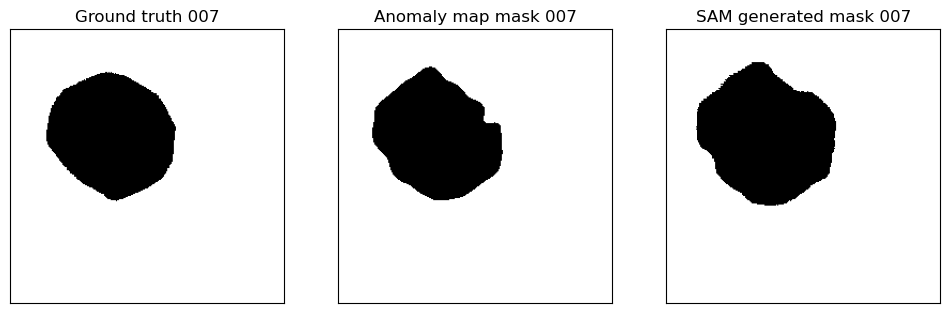

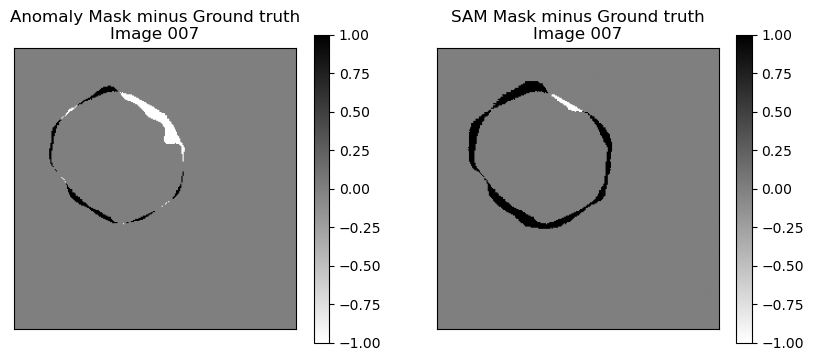

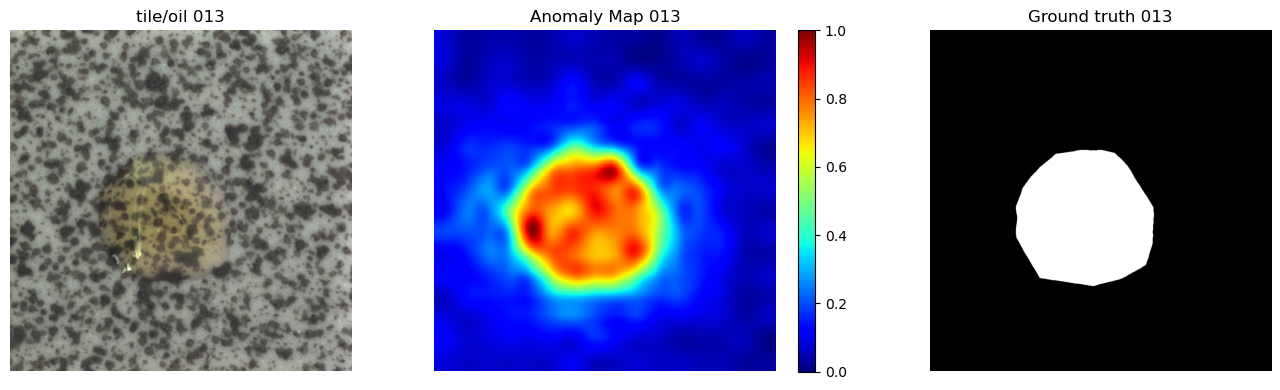

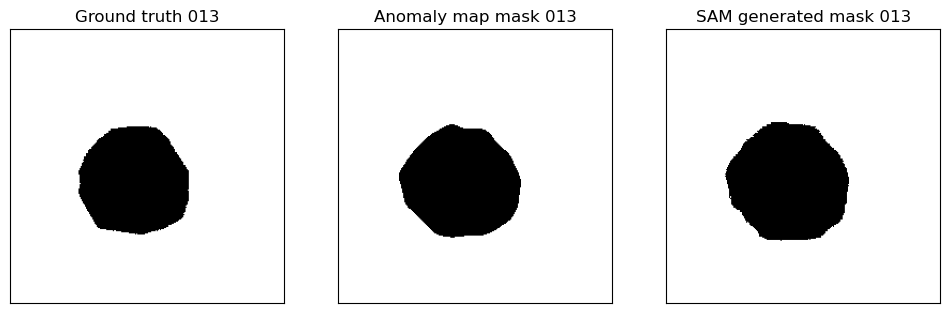

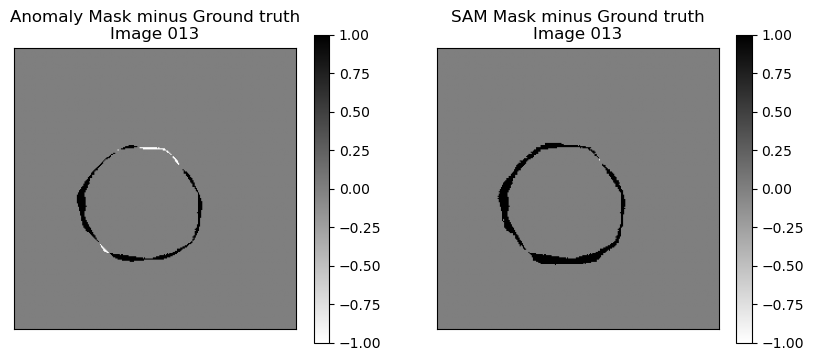

tile_oil_017 Dice overlap for Ground Truth and Anomaly Map mask:  0.9509685577973214
tile_oil_017 Dice overlap for Ground Truth and SAM mask:          0.9188861985472155
tile_oil_017 recall score for Ground Truth and Anomaly map mask:  0.9906586826347306
tile_oil_017 recall score for Ground Truth and SAM mask:          0.9998802395209581
tile_oil_007 Dice overlap for Ground Truth and Anomaly Map mask:  0.9509685577973214
tile_oil_007 Dice overlap for Ground Truth and SAM mask:          0.9188861985472155
tile_oil_007 recall score for Ground Truth and Anomaly map mask:  0.9906586826347306
tile_oil_007 recall score for Ground Truth and SAM mask:          0.9998802395209581
tile_oil_013 Dice overlap for Ground Truth and Anomaly Map mask:  0.9509685577973214
tile_oil_013 Dice overlap for Ground Truth and SAM mask:          0.9188861985472155
tile_oil_013 recall score for Ground Truth and Anomaly map mask:  0.9906586826347306
tile_oil_013 recall score for Ground Truth and SAM mask:         

In [ ]:
DATA_DIR = "mvtec_anomaly_detection/"

category = "tile"
anomaly = "oil"
use_test_image_num = False # set to True to set num_to_show equal to all the test images 
num_to_show = 3

show_images = True

# Loading images
train_folder = DATA_DIR + f"{category}/train/good"
test_folder = DATA_DIR + f"{category}/test/{anomaly}"
ground_truth_folder = DATA_DIR + f"{category}/ground_truth/{anomaly}"

train_image_paths = sorted(glob.glob(train_folder + "/*.png"))
test_image_paths = sorted(glob.glob(test_folder + "/*.png"))
ground_truth_paths = sorted(glob.glob(ground_truth_folder + "/*.png"))

Train_Images = [Image.open(p).convert("RGB") for p in train_image_paths]
Test_Images = [Image.open(p).convert("RGB") for p in test_image_paths]
Truth_Images = [Image.open(p).convert("RGB") for p in ground_truth_paths]

model.eval()

anomaly_calculator = Calculate_Anomaly_And_Mask(model, Train_Images, Test_Images)

# Computing anomaly maps
Anomaly_Maps = anomaly_calculator.Compute_Anomaly_Mask7()  # shape [num_test, 256, 256]


# Visualizing some random test images with their anomaly maps
if (use_test_image_num==True):
    num_to_show = len(Test_Images)
indices = random.sample(range(len(Test_Images)), num_to_show)


anomaly_map_dice_overlaps = []
anomaly_map_recall_scores = []
SAM_mask_dice_overlaps = []
SAM_mask_recall_scores = []


for i, idx in enumerate(indices): #Change to "for idx in range(len(Test_Images)):" to get all images in a category
    anomaly_map_unnorm = Anomaly_Maps[idx]

    # Normalizing anomaly map (already did that in the function, but now the max value is 255)
    anomaly_map = (anomaly_map_unnorm - anomaly_map_unnorm.min()) / (anomaly_map_unnorm.max() - anomaly_map_unnorm.min()) * 255
    anomaly_map = anomaly_map.astype(np.uint8)
    cv2.imwrite(f"results/{category}_{anomaly}_{str(idx).zfill(3)}_anomaly_map.png", anomaly_map)

    # Creating a simple naive mask where >= 0.5 * 255 intensity is marked as an anomaly
    anomaly_map_mask = np.where(anomaly_map >= 0.5 * 255, 1.0, 0.0)
    anomaly_map_mask = anomaly_map_mask.astype(int)
    cv2.imwrite(f"results/{category}_{anomaly}_{str(idx).zfill(3)}_anomaly_map_mask.png", anomaly_map_mask)

    if (anomaly!="good"):
        ground_truth_path = DATA_DIR + f"{category}/ground_truth/{anomaly}/{str(idx).zfill(3)}_mask.png"
        ground_truth = cv2.imread(ground_truth_path)

        # Resizing ground truth to 256 x 256
        ground_truth = cv2.resize(ground_truth, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)[:, :, 1]
        ground_truth = (ground_truth - ground_truth.min()) / (ground_truth.max() - ground_truth.min())
        ground_truth = ground_truth.astype(int)
    else:
        ground_truth = np.zeros((256, 256))

    # Finding local peaks for SAM Mask
    image_coords = cv2.imread(f"results/{category}_{anomaly}_{str(idx).zfill(3)}_anomaly_map.png", cv2.IMREAD_GRAYSCALE)
    im = img_as_float(image_coords)
    image_max = ndi.maximum_filter(im, size=20, mode='constant')
    coordinates = peak_local_max(im, min_distance=20, threshold_rel=0.7)

    # Creating SAM model
    sam_checkpoint = "sam_vit_b_01ec64.pth"
    model_type = "vit_b"
    device = "cuda" if torch.cuda.is_available() else "cpu"

    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device)



    image = cv2.imread(f"results/{category}_{anomaly}_{str(idx).zfill(3)}_anomaly_map.png")
    coordinates_flip = np.flip(coordinates, 1) # Fliping to make coordinates make sense
    predictor = SamPredictor(sam)
    predictor.set_image(image)
    input_point = coordinates_flip
    input_label = np.ones(len(input_point))

    # Creating SAM mask
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )

    # Saving SAM mask. 
    SAM_mask = masks[0].astype(int)
    cv2.imwrite(f"results/{category}_{anomaly}_{str(idx).zfill(3)}_SAM_mask.png", SAM_mask)

    # Calculating Dice overlap and recall scores
    anomaly_dice_overlap = f1_score(ground_truth.flatten(), anomaly_map_mask.flatten())
    anomaly_map_recall = recall_score(ground_truth.flatten(), anomaly_map_mask.flatten())
    SAM_dice_overlap = f1_score(ground_truth.flatten(), SAM_mask.flatten())
    SAM_recall = recall_score(ground_truth.flatten(), SAM_mask.flatten())
    anomaly_map_dice_overlaps.append(anomaly_dice_overlap)
    anomaly_map_recall_scores.append(anomaly_map_recall)
    SAM_mask_dice_overlaps.append(SAM_dice_overlap)
    SAM_mask_recall_scores.append(SAM_recall)



    if (show_images==False):
        pass

    else:
        plt.figure(figsize=(14, 4))
        test_img = Test_Images[idx]
        if (anomaly!="good"):
            ground_truth_image = Truth_Images[idx]
        else:
            ground_truth_image = ground_truth

        # Show test image
        plt.subplot(1, 3, 1)
        plt.imshow(test_img)
        plt.title(f"{category}/{anomaly} {str(idx).zfill(3)}")
        plt.axis('off')

        # Show anomaly map
        plt.subplot(1, 3, 2)
        plt.imshow(anomaly_map_unnorm, cmap='jet', vmin = 0, vmax = 1)
        plt.title(f"Anomaly Map {str(idx).zfill(3)}")
        plt.axis('off')
        plt.colorbar()

        # Show ground truth
        plt.subplot(1, 3, 3)
        plt.imshow(ground_truth_image, cmap='binary')
        plt.title(f"Ground truth {str(idx).zfill(3)}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()


        # Individual masks and Ground Truth
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(ground_truth, cmap="binary")
        plt.title(f"Ground truth {str(idx).zfill(3)}")
        # plt.axis("off")
        plt.yticks([])
        plt.xticks([])
        # plt.colorbar()
        plt.subplot(1, 3, 2)
        plt.imshow(anomaly_map_mask, cmap="binary")
        plt.title(f"Anomaly map mask {str(idx).zfill(3)}")
        # plt.axis("off")
        plt.yticks([])
        plt.xticks([])
        # plt.colorbar()
        plt.subplot(1, 3, 3)
        plt.imshow(SAM_mask, cmap="binary")
        plt.title(f"SAM generated mask {str(idx).zfill(3)}")
        # plt.axis("off")
        plt.yticks([])
        plt.xticks([])
        # plt.colorbar()
        plt.show()

        # Masks minus Ground Truth
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(anomaly_map_mask - ground_truth, cmap="binary")
        plt.title(f"Anomaly Mask minus Ground truth\nImage {str(idx).zfill(3)}")
        plt.yticks([])
        plt.xticks([])
        plt.colorbar()
        plt.subplot(1, 2, 2)
        plt.imshow(SAM_mask - ground_truth, cmap="binary")
        plt.title(f"SAM Mask minus Ground truth\nImage {str(idx).zfill(3)}")
        plt.yticks([])
        plt.xticks([])
        plt.colorbar()
        plt.show()

for idx in indices:
    print(f"{category}_{anomaly}_{str(idx).zfill(3)} Dice overlap for Ground Truth and Anomaly Map mask: ", anomaly_dice_overlap)
    print(f"{category}_{anomaly}_{str(idx).zfill(3)} Dice overlap for Ground Truth and SAM mask:         ", SAM_dice_overlap)
    print(f"{category}_{anomaly}_{str(idx).zfill(3)} recall score for Ground Truth and Anomaly map mask: ", anomaly_map_recall)
    print(f"{category}_{anomaly}_{str(idx).zfill(3)} recall score for Ground Truth and SAM mask:         ", SAM_recall)
    

mean_anomaly_dice_overlap = sum(anomaly_map_dice_overlaps) / len(anomaly_map_dice_overlaps)
mean_SAM_dice_overlap = sum(SAM_mask_dice_overlaps) / len(SAM_mask_dice_overlaps)
mean_anomaly_recall = sum(anomaly_map_recall_scores) / len(anomaly_map_recall_scores)
mean_SAM_recall = sum(SAM_mask_recall_scores) / len(SAM_mask_recall_scores)
print(f"Average Dice Overlap score for Anomaly maps in {category}/{anomaly}: ", mean_anomaly_dice_overlap)
print(f"Average Dice Overlap score for SAM mask map in {category}/{anomaly}: ", mean_SAM_dice_overlap)
print(f"Average recall score for Anomaly maps in {category}/{anomaly}: ", mean_anomaly_recall)
print(f"Average recall score for SAM mask map in {category}/{anomaly}: ", mean_SAM_recall)


tile_oil_001 Dice overlap for Ground Truth and Anomaly Map mask:  0.9319517663455129
tile_oil_001 Dice overlap for Ground Truth and SAM mask:          0.13178726725387446


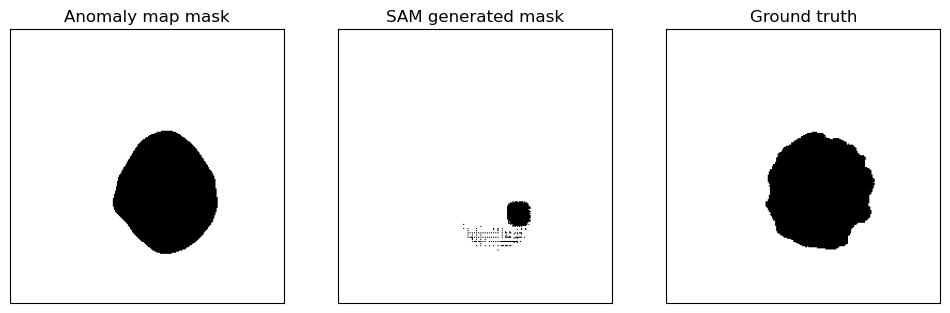

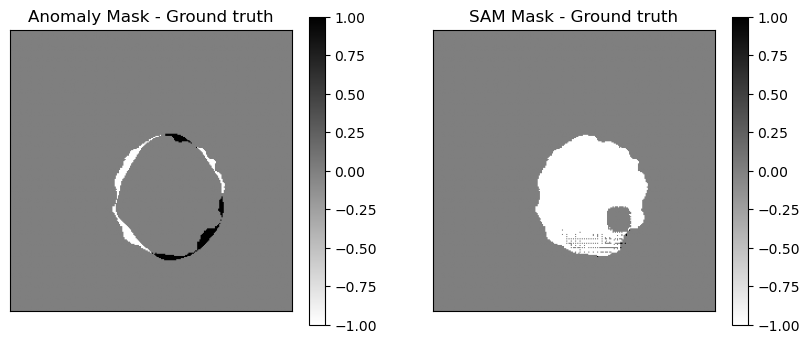

In [ ]:
# To check individual anomalies

category = "tile"
anomaly = "oil"
idx = 1

anomaly_map_mask_to_show = cv2.imread(f"results/{category}_{anomaly}_{str(idx).zfill(3)}_anomaly_map_mask.png", cv2.IMREAD_GRAYSCALE)
SAM_mask_to_show = cv2.imread(f"results/{category}_{anomaly}_{str(idx).zfill(3)}_SAM_mask.png", cv2.IMREAD_GRAYSCALE)
ground_truth_path = DATA_DIR + f"{category}/ground_truth/{anomaly}/{str(idx).zfill(3)}_mask.png"
ground_truth = cv2.imread(ground_truth_path)
# Resizing ground truth to 256 x 256
ground_truth = cv2.resize(ground_truth, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)[:, :, 1]
ground_truth = (ground_truth - ground_truth.min()) / (ground_truth.max() - ground_truth.min())
ground_truth_to_show = ground_truth.astype(int)

anomaly_dice_overlap = f1_score(ground_truth_to_show.flatten(), anomaly_map_mask_to_show.flatten())
SAM_dice_overlap = f1_score(ground_truth_to_show.flatten(), SAM_mask_to_show.flatten())
print(f"{category}_{anomaly}_{str(idx).zfill(3)} Dice overlap for Ground Truth and Anomaly Map mask: ", anomaly_dice_overlap)
print(f"{category}_{anomaly}_{str(idx).zfill(3)} Dice overlap for Ground Truth and SAM mask:         ", SAM_dice_overlap)


# Individual masks and Ground Truth
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(anomaly_map_mask_to_show, cmap="binary")
plt.title("Anomaly map mask")
# plt.axis("off")
plt.yticks([])
plt.xticks([])
# plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(SAM_mask_to_show, cmap="binary")
plt.title("SAM generated mask")
# plt.axis("off")
plt.yticks([])
plt.xticks([])
# plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(ground_truth_to_show, cmap="binary")
plt.title("Ground truth")
# plt.axis("off")
plt.yticks([])
plt.xticks([])
# plt.colorbar()
plt.show


# Masks minus Ground Truth
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(anomaly_map_mask_to_show - ground_truth_to_show, cmap="binary")
plt.title("Anomaly Mask - Ground truth")
plt.yticks([])
plt.xticks([])
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(SAM_mask_to_show - ground_truth_to_show, cmap="binary")
plt.title("SAM Mask - Ground truth")
plt.yticks([])
plt.xticks([])
plt.colorbar()


===== BEST / WORST RESULTS =====
Best SAM:    idx 14,   Dice=0.7890
Worst SAM:   idx 4,  Dice=0.0000
Best ANOM:   idx 14,  Dice=0.6347
Worst ANOM:  idx 4, Dice=0.0000


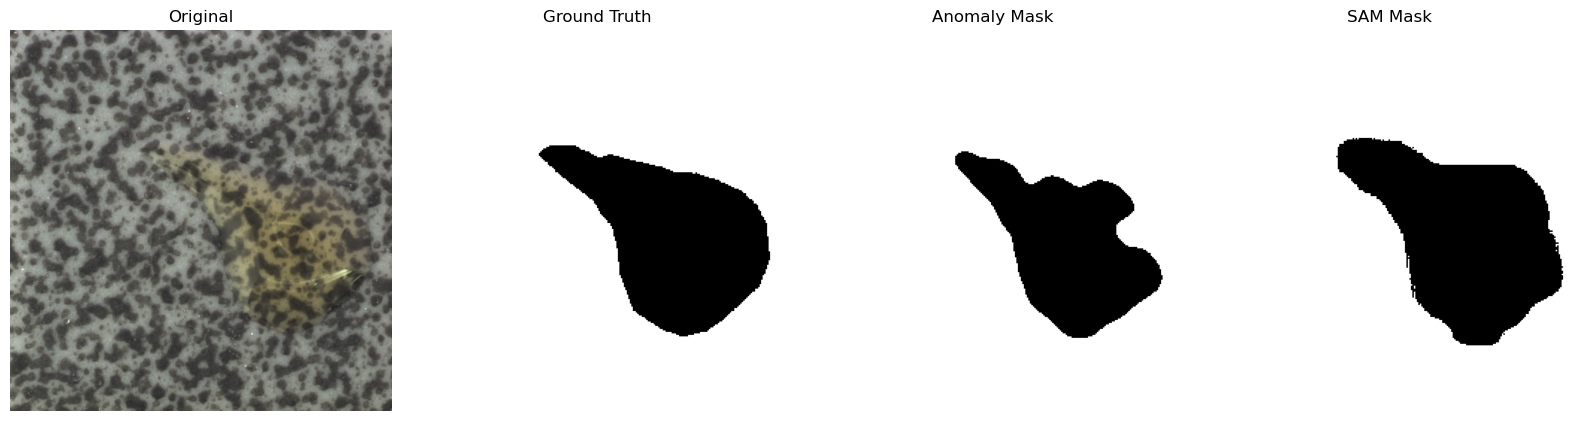

Saved: best_worst_examples/best_SAM_014.png


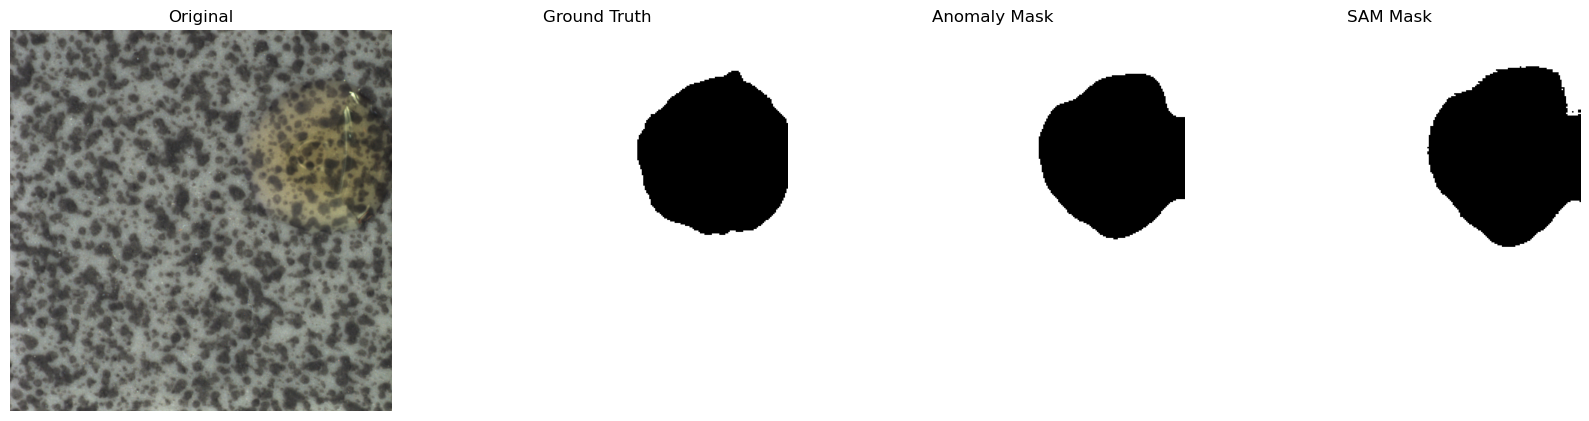

Saved: best_worst_examples/worst_SAM_004.png


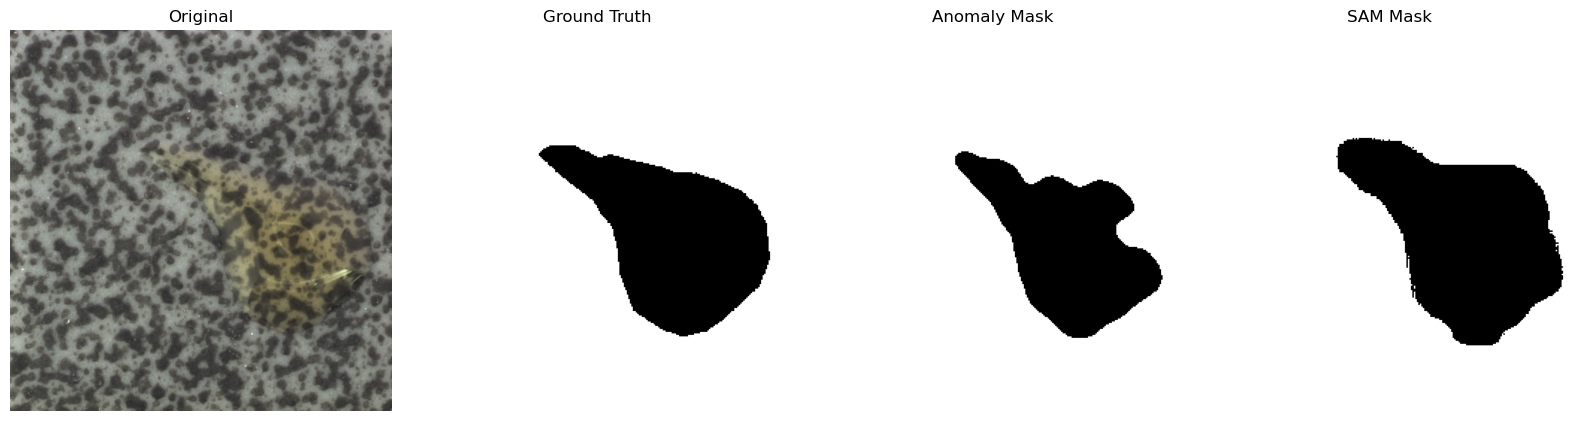

Saved: best_worst_examples/best_AnomalyMask_014.png


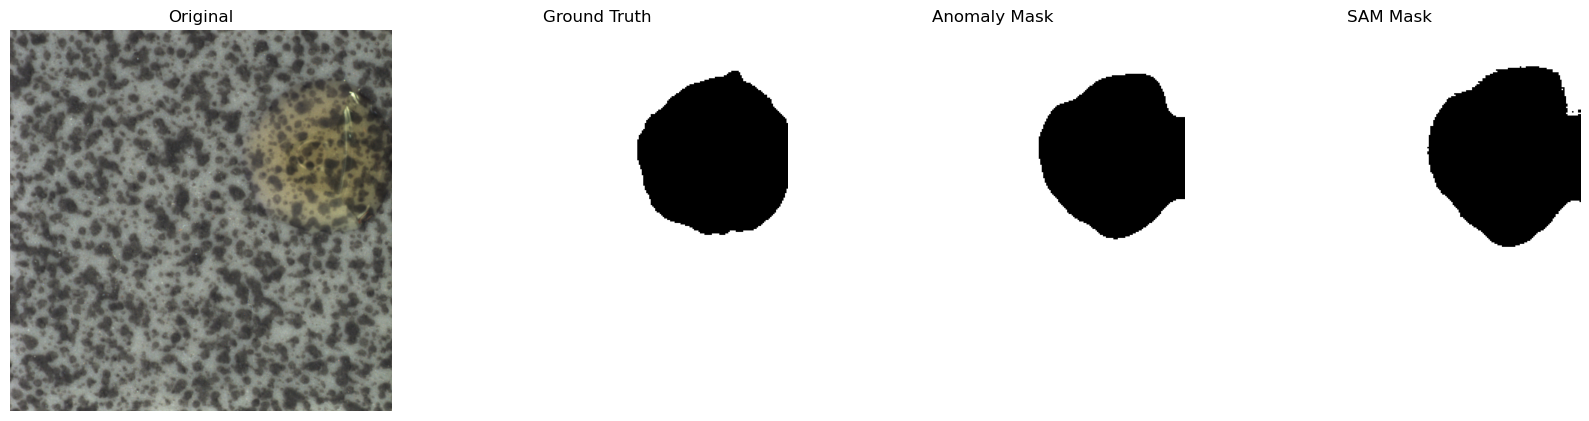

Saved: best_worst_examples/worst_AnomalyMask_004.png


In [ ]:

# Watching which examples perform best and worst
save_dir = "best_worst_examples"

# Convert Dice lists to arrays
dice_sam = np.array(SAM_mask_dice_overlaps)
dice_anom = np.array(anomaly_map_dice_overlaps)

# Finding best & worst indices for each method
best_sam   = np.argmax(dice_sam)
worst_sam  = np.argmin(dice_sam)

best_anom  = np.argmax(dice_anom)
worst_anom = np.argmin(dice_anom)

print("\n===== BEST / WORST RESULTS =====")
print(f"Best SAM:    idx {best_sam},   Dice={dice_sam[best_sam]:.4f}")
print(f"Worst SAM:   idx {worst_sam},  Dice={dice_sam[worst_sam]:.4f}")
print(f"Best ANOM:   idx {best_anom},  Dice={dice_anom[best_anom]:.4f}")
print(f"Worst ANOM:  idx {worst_anom}, Dice={dice_anom[worst_anom]:.4f}")

test_folder = DATA_DIR + f"{category}/test/{anomaly}"
test_image_paths = sorted(glob.glob(test_folder + "/*.png"))
Test_Images = [Image.open(p).convert("RGB") for p in test_image_paths]


def visualize_and_save(idx, title_prefix):
    """Displays: original image, GT mask, anomaly mask, SAM mask"""
    
    # Load original image
    img = np.array(Test_Images[idx])

    # Loading masks
    path_anom = f"results/{category}_{anomaly}_{str(idx).zfill(3)}_anomaly_map_mask.png"
    path_sam  = f"results/{category}_{anomaly}_{str(idx).zfill(3)}_SAM_mask.png"
    path_gt   = f"{DATA_DIR}{category}/ground_truth/{anomaly}/{str(idx).zfill(3)}_mask.png"

    anom_mask = cv2.imread(path_anom, cv2.IMREAD_GRAYSCALE).astype(int)
    sam_mask  = cv2.imread(path_sam,  cv2.IMREAD_GRAYSCALE).astype(int)

    gt_raw    = cv2.imread(path_gt)
    gt_mask   = cv2.resize(gt_raw, (256, 256))[:, :, 1]
    gt_mask   = ((gt_mask - gt_mask.min()) / (gt_mask.max() - gt_mask.min())).astype(int)

    # Plot results
    fig, axes = plt.subplots(1, 4, figsize=(16, 5))

    axes[0].imshow(img)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(gt_mask, cmap="binary")
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    axes[2].imshow(anom_mask, cmap="binary")
    axes[2].set_title("Anomaly Mask")
    axes[2].axis("off")

    axes[3].imshow(sam_mask, cmap="binary")
    axes[3].set_title("SAM Mask")
    axes[3].axis("off")

    plt.tight_layout()

    # Save
    outfile = os.path.join(save_dir, f"{title_prefix}_{str(idx).zfill(3)}.png")
    plt.savefig(outfile, dpi=150)
    plt.show()

    print(f"Saved: {outfile}")

visualize_and_save(best_sam,  "best_SAM")
visualize_and_save(worst_sam, "worst_SAM")

visualize_and_save(best_anom,  "best_AnomalyMask")
visualize_and_save(worst_anom, "worst_AnomalyMask")

In [10]:
# Same as before, just copied some code from earlier and changed some things
# We basically just add another loop that goes through different anomaly types and different catagories.
DATA_DIR = "mvtec_anomaly_detection/"
SCORES_DIR = "scores"
os.makedirs(SCORES_DIR, exist_ok=True)

# All MVTec categories
mvtec_categories = sorted(os.listdir(DATA_DIR))

# Output CSV file
csv_path = os.path.join(SCORES_DIR, "mvtec_all_scores.csv")

# CSV header
header = [
    "category",
    "anomaly_type",
    "num_images",
    "dice_anomaly_mean",
    "dice_anomaly_std",
    "dice_sam_mean",
    "dice_sam_std",
    "recall_anom_mean",
    "recall_anom_std",
    "recall_sam_mean",
    "recall_sam_std",
    "anom_score_mean_mean",
    "anom_score_mean_std",
    "anom_score_max_mean",
    "anom_score_max_std",
    "anom_score_percentile_mean",
    "anom_score_percentile_std"
]

# Create CSV
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(header)

# Initializing SAM
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)

for category in mvtec_categories:

    test_dir = os.path.join(DATA_DIR, category, "test")

    # All anomaly types inside category
    anomalies = sorted(os.listdir(test_dir))

    for anomaly in anomalies:

        print(f"\n=== Processing {category}/{anomaly} ===")
       
        train_folder = f"{DATA_DIR}{category}/train/good"
        test_folder = f"{DATA_DIR}{category}/test/{anomaly}"
        gt_folder = f"{DATA_DIR}{category}/ground_truth/{anomaly}"


        train_image_paths = sorted(glob.glob(train_folder + "/*.png"))
        test_image_paths = sorted(glob.glob(test_folder + "/*.png"))
        ground_truth_paths = sorted(glob.glob(gt_folder + "/*.png"))

        Train_Images = [Image.open(p).convert("RGB") for p in train_image_paths]
        Test_Images = [Image.open(p).convert("RGB") for p in test_image_paths]
        Truth_Images = [Image.open(p).convert("RGB") for p in ground_truth_paths]

        # Running anomaly calculator
        anomaly_calculator = Calculate_Anomaly_And_Mask(model, Train_Images, Test_Images)
        Anomaly_Maps = anomaly_calculator.Compute_Anomaly_Mask7()

        # Extracting per-image anomaly scores (3 types)
        # Shape: (3, num_images)
        anomaly_scores = anomaly_calculator.Anomaly_Scores

        # Evaluating segmentation (without visualization)
        anomaly_dice_list = []
        sam_dice_list = []
        anomaly_map_dice_overlaps = []
        anomaly_map_recall_scores = []
        SAM_mask_dice_overlaps = []
        SAM_mask_recall_scores = []
        for idx in tqdm(range(len(Test_Images)), desc=f"{category}/{anomaly} images"): 
            anomaly_map_unnorm = Anomaly_Maps[idx]

            # Normalizing anomaly map (already did that in the function, but now the max value is 255)
            anomaly_map = (anomaly_map_unnorm - anomaly_map_unnorm.min()) / (anomaly_map_unnorm.max() - anomaly_map_unnorm.min()) * 255
            anomaly_map = anomaly_map.astype(np.uint8)
            cv2.imwrite(f"results/{category}_{anomaly}_{str(idx).zfill(3)}_anomaly_map.png", anomaly_map)

            # Creating a simple naive mask where >= 0.5 * 255 intensity is marked as an anomaly
            anomaly_map_mask = np.where(anomaly_map >= 0.5 * 255, 1.0, 0.0)
            anomaly_map_mask = anomaly_map_mask.astype(np.uint8)
            cv2.imwrite(f"results/{category}_{anomaly}_{str(idx).zfill(3)}_anomaly_map_mask.png", anomaly_map_mask)
            # We only have a ground truth for anomaly data, so we need an if statement here:
            if anomaly=="good":
                anomaly_map_dice_overlaps = ""
                anomaly_map_dice_overlaps = ""
            else:
                ground_truth_path = DATA_DIR + f"{category}/ground_truth/{anomaly}/{str(idx).zfill(3)}_mask.png"
                ground_truth = cv2.imread(ground_truth_path)

                # Resizing ground truth to 256 x 256 to match model output
                ground_truth = cv2.resize(ground_truth, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)[:, :, 1]
                ground_truth = (ground_truth - ground_truth.min()) / (ground_truth.max() - ground_truth.min())
                ground_truth = (ground_truth > 0).astype(np.uint8)  # binary mask

                # Finding local peaks for SAM Mask
                image_coords = cv2.imread(f"results/{category}_{anomaly}_{str(idx).zfill(3)}_anomaly_map.png", cv2.IMREAD_GRAYSCALE)
                im = img_as_float(image_coords)
                image_max = ndi.maximum_filter(im, size=20, mode='constant')
                coordinates = peak_local_max(im, min_distance=20, threshold_rel=0.7) # 

                image = cv2.imread(f"results/{category}_{anomaly}_{str(idx).zfill(3)}_anomaly_map.png")
                coordinates_flip = np.flip(coordinates, 1) # Flipping to make coordinates make sense
                predictor = SamPredictor(sam)
                predictor.set_image(image)
                input_point = coordinates_flip
                input_label = np.ones(len(input_point))

                # Creating SAM mask
                masks, scores, logits = predictor.predict(
                    point_coords=input_point,
                    point_labels=input_label,
                    multimask_output=False,
                )

                # Saving SAM mask. 
                SAM_mask = masks[0].astype(int)
                cv2.imwrite(f"results/{category}_{anomaly}_{str(idx).zfill(3)}_SAM_mask.png", SAM_mask)

                # Calculating Dice overlap scores
                anomaly_dice_overlap = f1_score(ground_truth.flatten(), anomaly_map_mask.flatten())
                anomaly_map_recall = recall_score(ground_truth.flatten(), anomaly_map_mask.flatten())
                SAM_dice_overlap = f1_score(ground_truth.flatten(), SAM_mask.flatten())
                SAM_recall = recall_score(ground_truth.flatten(), SAM_mask.flatten())
                anomaly_map_dice_overlaps.append(anomaly_dice_overlap)
                anomaly_map_recall_scores.append(anomaly_map_recall)
                SAM_mask_dice_overlaps.append(SAM_dice_overlap)
                SAM_mask_recall_scores.append(SAM_recall)

        if anomaly=="good":
            mean_dice_anom = ""
            std_dice_anom = ""
            mean_dice_sam = ""
            std_dice_sam = ""
        else:
            # Converting lists into np arrays
            anomaly_dice_list = np.array(anomaly_map_dice_overlaps) #Weird names i know.
            anomaly_recall_list = np.array(anomaly_map_recall_scores)
            sam_dice_list = np.array(SAM_mask_dice_overlaps)
            sam_recall_list = np.array(SAM_mask_recall_scores)

            # Computing summary statistics
            mean_dice_anom = f"{np.mean(anomaly_dice_list):.5f}"
            std_dice_anom = f"{np.std(anomaly_dice_list):.5f}"
            mean_recall_anom = f"{np.mean(anomaly_recall_list):.5f}"
            std_recall_anom = f"{np.std(anomaly_recall_list):.5f}"

            mean_dice_sam = f"{np.mean(sam_dice_list):.5f}"
            std_dice_sam = f"{np.std(sam_dice_list):.5f}"
            mean_recall_sam = f"{np.mean(sam_recall_list):.5f}"
            std_recall_sam = f"{np.std(sam_recall_list):.5f}"

        # Anomaly scores (shape: 3 × N)
        score_mean = anomaly_scores[0]  # per-image mean score
        score_max = anomaly_scores[1]   # per-image max score
        score_pct = anomaly_scores[2]   # per-image percentile95 score

        # Compute stats
        score_mean_avg = np.mean(score_mean)
        score_mean_std = np.std(score_mean)

        score_max_avg = np.mean(score_max)
        score_max_std = np.std(score_max)

        score_pct_avg = np.mean(score_pct)
        score_pct_std = np.std(score_pct)

        # Save to CSV
        with open(csv_path, "a", newline="") as f:
            writer = csv.writer(f, delimiter=',')
            writer.writerow([
                category,
                anomaly,
                len(Test_Images),
            mean_dice_anom,
            std_dice_anom,
            mean_dice_sam,
            std_dice_sam,
            mean_recall_anom,
            std_recall_anom,
            mean_recall_sam,
            std_recall_sam,
            f"{score_mean_avg:.5f}",
            f"{score_mean_std:.5f}",
            f"{score_max_avg:.5f}",
            f"{score_max_std:.5f}",
            f"{score_pct_avg:.5f}",
            f"{score_pct_std:.5f}"
            ])

        print(f"Saved stats for {category}/{anomaly}\n")
        print(f'Mean Dice: {category}/{anomaly} {mean_dice_anom}')
        print(f'Mean Recall: {category}/{anomaly} {mean_recall_anom}')

print("\nSaved full CSV to: ", csv_path)


=== Processing bottle/broken_large ===


bottle/broken_large images: 100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Saved stats for bottle/broken_large

Mean Dice: bottle/broken_large 0.68431
Mean Recall: bottle/broken_large 0.59656

=== Processing bottle/broken_small ===


bottle/broken_small images: 100%|██████████| 22/22 [00:06<00:00,  3.64it/s]


Saved stats for bottle/broken_small

Mean Dice: bottle/broken_small 0.66728
Mean Recall: bottle/broken_small 0.58653

=== Processing bottle/contamination ===


bottle/contamination images: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]


Saved stats for bottle/contamination

Mean Dice: bottle/contamination 0.73126
Mean Recall: bottle/contamination 0.74021

=== Processing bottle/good ===


bottle/good images: 100%|██████████| 20/20 [00:00<00:00, 1122.94it/s]


Saved stats for bottle/good

Mean Dice: bottle/good 
Mean Recall: bottle/good 0.74021

=== Processing cable/bent_wire ===


cable/bent_wire images: 100%|██████████| 13/13 [00:03<00:00,  3.63it/s]


Saved stats for cable/bent_wire

Mean Dice: cable/bent_wire 0.68434
Mean Recall: cable/bent_wire 0.76907

=== Processing cable/cable_swap ===


cable/cable_swap images: 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]


Saved stats for cable/cable_swap

Mean Dice: cable/cable_swap 0.74392
Mean Recall: cable/cable_swap 0.88035

=== Processing cable/combined ===


cable/combined images: 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]


Saved stats for cable/combined

Mean Dice: cable/combined 0.62966
Mean Recall: cable/combined 0.55958

=== Processing cable/cut_inner_insulation ===


cable/cut_inner_insulation images: 100%|██████████| 14/14 [00:03<00:00,  3.64it/s]


Saved stats for cable/cut_inner_insulation

Mean Dice: cable/cut_inner_insulation 0.57925
Mean Recall: cable/cut_inner_insulation 0.77786

=== Processing cable/cut_outer_insulation ===


cable/cut_outer_insulation images: 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


Saved stats for cable/cut_outer_insulation

Mean Dice: cable/cut_outer_insulation 0.45731
Mean Recall: cable/cut_outer_insulation 0.79818

=== Processing cable/good ===


cable/good images: 100%|██████████| 58/58 [00:00<00:00, 1068.41it/s]


Saved stats for cable/good

Mean Dice: cable/good 
Mean Recall: cable/good 0.79818

=== Processing cable/missing_cable ===


cable/missing_cable images: 100%|██████████| 12/12 [00:03<00:00,  3.54it/s]


Saved stats for cable/missing_cable

Mean Dice: cable/missing_cable 0.87345
Mean Recall: cable/missing_cable 0.78795

=== Processing cable/missing_wire ===


cable/missing_wire images: 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


Saved stats for cable/missing_wire

Mean Dice: cable/missing_wire 0.71368
Mean Recall: cable/missing_wire 0.99042

=== Processing cable/poke_insulation ===


cable/poke_insulation images: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


Saved stats for cable/poke_insulation

Mean Dice: cable/poke_insulation 0.64786
Mean Recall: cable/poke_insulation 0.80401

=== Processing capsule/crack ===


capsule/crack images: 100%|██████████| 23/23 [00:06<00:00,  3.62it/s]


Saved stats for capsule/crack

Mean Dice: capsule/crack 0.35243
Mean Recall: capsule/crack 0.77724

=== Processing capsule/faulty_imprint ===


capsule/faulty_imprint images: 100%|██████████| 22/22 [00:06<00:00,  3.63it/s]


Saved stats for capsule/faulty_imprint

Mean Dice: capsule/faulty_imprint 0.38782
Mean Recall: capsule/faulty_imprint 0.86069

=== Processing capsule/good ===


capsule/good images: 100%|██████████| 23/23 [00:00<00:00, 1113.72it/s]


Saved stats for capsule/good

Mean Dice: capsule/good 
Mean Recall: capsule/good 0.86069

=== Processing capsule/poke ===


capsule/poke images: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]


Saved stats for capsule/poke

Mean Dice: capsule/poke 0.35616
Mean Recall: capsule/poke 0.90162

=== Processing capsule/scratch ===


capsule/scratch images: 100%|██████████| 23/23 [00:06<00:00,  3.63it/s]


Saved stats for capsule/scratch

Mean Dice: capsule/scratch 0.47421
Mean Recall: capsule/scratch 0.64789

=== Processing capsule/squeeze ===


capsule/squeeze images: 100%|██████████| 20/20 [00:05<00:00,  3.60it/s]


Saved stats for capsule/squeeze

Mean Dice: capsule/squeeze 0.47024
Mean Recall: capsule/squeeze 0.65253

=== Processing carpet/color ===


carpet/color images: 100%|██████████| 19/19 [00:05<00:00,  3.59it/s]


Saved stats for carpet/color

Mean Dice: carpet/color 0.65441
Mean Recall: carpet/color 0.97164

=== Processing carpet/cut ===


carpet/cut images: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]


Saved stats for carpet/cut

Mean Dice: carpet/cut 0.77559
Mean Recall: carpet/cut 0.71197

=== Processing carpet/good ===


carpet/good images: 100%|██████████| 28/28 [00:00<00:00, 997.22it/s]


Saved stats for carpet/good

Mean Dice: carpet/good 
Mean Recall: carpet/good 0.71197

=== Processing carpet/hole ===


carpet/hole images: 100%|██████████| 17/17 [00:04<00:00,  3.58it/s]


Saved stats for carpet/hole

Mean Dice: carpet/hole 0.77935
Mean Recall: carpet/hole 0.81041

=== Processing carpet/metal_contamination ===


carpet/metal_contamination images: 100%|██████████| 17/17 [00:04<00:00,  3.55it/s]


Saved stats for carpet/metal_contamination

Mean Dice: carpet/metal_contamination 0.50192
Mean Recall: carpet/metal_contamination 0.97503

=== Processing carpet/thread ===


carpet/thread images: 100%|██████████| 19/19 [00:05<00:00,  3.59it/s]


Saved stats for carpet/thread

Mean Dice: carpet/thread 0.41371
Mean Recall: carpet/thread 0.87690

=== Processing grid/bent ===


grid/bent images: 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]


Saved stats for grid/bent

Mean Dice: grid/bent 0.43734
Mean Recall: grid/bent 0.80915

=== Processing grid/broken ===


grid/broken images: 100%|██████████| 12/12 [00:03<00:00,  3.55it/s]


Saved stats for grid/broken

Mean Dice: grid/broken 0.33370
Mean Recall: grid/broken 0.93006

=== Processing grid/glue ===


grid/glue images: 100%|██████████| 11/11 [00:03<00:00,  3.59it/s]


Saved stats for grid/glue

Mean Dice: grid/glue 0.43881
Mean Recall: grid/glue 0.97520

=== Processing grid/good ===


grid/good images: 100%|██████████| 21/21 [00:00<00:00, 959.26it/s]


Saved stats for grid/good

Mean Dice: grid/good 
Mean Recall: grid/good 0.97520

=== Processing grid/metal_contamination ===


grid/metal_contamination images: 100%|██████████| 11/11 [00:03<00:00,  3.60it/s]


Saved stats for grid/metal_contamination

Mean Dice: grid/metal_contamination 0.35670
Mean Recall: grid/metal_contamination 0.99625

=== Processing grid/thread ===


grid/thread images: 100%|██████████| 11/11 [00:03<00:00,  3.57it/s]


Saved stats for grid/thread

Mean Dice: grid/thread 0.44223
Mean Recall: grid/thread 0.86696

=== Processing hazelnut/crack ===


hazelnut/crack images: 100%|██████████| 18/18 [00:05<00:00,  3.56it/s]


Saved stats for hazelnut/crack

Mean Dice: hazelnut/crack 0.70058
Mean Recall: hazelnut/crack 0.93230

=== Processing hazelnut/cut ===


hazelnut/cut images: 100%|██████████| 17/17 [00:04<00:00,  3.58it/s]


Saved stats for hazelnut/cut

Mean Dice: hazelnut/cut 0.42886
Mean Recall: hazelnut/cut 0.93961

=== Processing hazelnut/good ===


hazelnut/good images: 100%|██████████| 40/40 [00:00<00:00, 854.33it/s]


Saved stats for hazelnut/good

Mean Dice: hazelnut/good 
Mean Recall: hazelnut/good 0.93961

=== Processing hazelnut/hole ===


hazelnut/hole images: 100%|██████████| 18/18 [00:05<00:00,  3.59it/s]


Saved stats for hazelnut/hole

Mean Dice: hazelnut/hole 0.69629
Mean Recall: hazelnut/hole 0.90203

=== Processing hazelnut/print ===


hazelnut/print images: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]


Saved stats for hazelnut/print

Mean Dice: hazelnut/print 0.68798
Mean Recall: hazelnut/print 0.82322

=== Processing leather/color ===


leather/color images: 100%|██████████| 19/19 [00:05<00:00,  3.59it/s]


Saved stats for leather/color

Mean Dice: leather/color 0.41672
Mean Recall: leather/color 0.98387

=== Processing leather/cut ===


leather/cut images: 100%|██████████| 19/19 [00:05<00:00,  3.58it/s]


Saved stats for leather/cut

Mean Dice: leather/cut 0.25857
Mean Recall: leather/cut 0.97110

=== Processing leather/fold ===


leather/fold images: 100%|██████████| 17/17 [00:04<00:00,  3.60it/s]


Saved stats for leather/fold

Mean Dice: leather/fold 0.47013
Mean Recall: leather/fold 0.99438

=== Processing leather/glue ===


leather/glue images: 100%|██████████| 19/19 [00:05<00:00,  3.60it/s]


Saved stats for leather/glue

Mean Dice: leather/glue 0.58933
Mean Recall: leather/glue 0.99543

=== Processing leather/good ===


leather/good images: 100%|██████████| 32/32 [00:00<00:00, 929.81it/s]


Saved stats for leather/good

Mean Dice: leather/good 
Mean Recall: leather/good 0.99543

=== Processing leather/poke ===


leather/poke images: 100%|██████████| 18/18 [00:04<00:00,  3.64it/s]


Saved stats for leather/poke

Mean Dice: leather/poke 0.10273
Mean Recall: leather/poke 1.00000

=== Processing metal_nut/bent ===


metal_nut/bent images: 100%|██████████| 25/25 [00:06<00:00,  3.64it/s]


Saved stats for metal_nut/bent

Mean Dice: metal_nut/bent 0.67431
Mean Recall: metal_nut/bent 0.72217

=== Processing metal_nut/color ===


metal_nut/color images: 100%|██████████| 22/22 [00:06<00:00,  3.59it/s]


Saved stats for metal_nut/color

Mean Dice: metal_nut/color 0.56397
Mean Recall: metal_nut/color 0.65219

=== Processing metal_nut/flip ===


metal_nut/flip images: 100%|██████████| 23/23 [00:06<00:00,  3.58it/s]


Saved stats for metal_nut/flip

Mean Dice: metal_nut/flip 0.81672
Mean Recall: metal_nut/flip 0.76390

=== Processing metal_nut/good ===


metal_nut/good images: 100%|██████████| 22/22 [00:00<00:00, 1154.95it/s]


Saved stats for metal_nut/good

Mean Dice: metal_nut/good 
Mean Recall: metal_nut/good 0.76390

=== Processing metal_nut/scratch ===


metal_nut/scratch images: 100%|██████████| 23/23 [00:06<00:00,  3.54it/s]


Saved stats for metal_nut/scratch

Mean Dice: metal_nut/scratch 0.71159
Mean Recall: metal_nut/scratch 0.69910

=== Processing pill/color ===


pill/color images: 100%|██████████| 25/25 [00:06<00:00,  3.60it/s]


Saved stats for pill/color

Mean Dice: pill/color 0.30933
Mean Recall: pill/color 0.88253

=== Processing pill/combined ===


pill/combined images: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]


Saved stats for pill/combined

Mean Dice: pill/combined 0.55297
Mean Recall: pill/combined 0.65213

=== Processing pill/contamination ===


pill/contamination images: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]


Saved stats for pill/contamination

Mean Dice: pill/contamination 0.68352
Mean Recall: pill/contamination 0.85920

=== Processing pill/crack ===


pill/crack images: 100%|██████████| 26/26 [00:07<00:00,  3.62it/s]


Saved stats for pill/crack

Mean Dice: pill/crack 0.47080
Mean Recall: pill/crack 0.79260

=== Processing pill/faulty_imprint ===


pill/faulty_imprint images: 100%|██████████| 19/19 [00:05<00:00,  3.60it/s]


Saved stats for pill/faulty_imprint

Mean Dice: pill/faulty_imprint 0.61003
Mean Recall: pill/faulty_imprint 0.72636

=== Processing pill/good ===


pill/good images: 100%|██████████| 26/26 [00:00<00:00, 784.50it/s]


Saved stats for pill/good

Mean Dice: pill/good 
Mean Recall: pill/good 0.72636

=== Processing pill/pill_type ===


pill/pill_type images: 100%|██████████| 9/9 [00:02<00:00,  3.59it/s]


Saved stats for pill/pill_type

Mean Dice: pill/pill_type 0.51749
Mean Recall: pill/pill_type 0.39505

=== Processing pill/scratch ===


pill/scratch images: 100%|██████████| 24/24 [00:06<00:00,  3.61it/s]


Saved stats for pill/scratch

Mean Dice: pill/scratch 0.62285
Mean Recall: pill/scratch 0.76417

=== Processing screw/good ===


screw/good images: 100%|██████████| 41/41 [00:00<00:00, 1071.30it/s]


Saved stats for screw/good

Mean Dice: screw/good 
Mean Recall: screw/good 0.76417

=== Processing screw/manipulated_front ===


screw/manipulated_front images: 100%|██████████| 24/24 [00:06<00:00,  3.58it/s]


Saved stats for screw/manipulated_front

Mean Dice: screw/manipulated_front 0.14849
Mean Recall: screw/manipulated_front 0.62501

=== Processing screw/scratch_head ===


screw/scratch_head images: 100%|██████████| 24/24 [00:06<00:00,  3.59it/s]


Saved stats for screw/scratch_head

Mean Dice: screw/scratch_head 0.09288
Mean Recall: screw/scratch_head 0.69173

=== Processing screw/scratch_neck ===


screw/scratch_neck images: 100%|██████████| 25/25 [00:06<00:00,  3.60it/s]


Saved stats for screw/scratch_neck

Mean Dice: screw/scratch_neck 0.38570
Mean Recall: screw/scratch_neck 0.83118

=== Processing screw/thread_side ===


screw/thread_side images: 100%|██████████| 23/23 [00:06<00:00,  3.54it/s]


Saved stats for screw/thread_side

Mean Dice: screw/thread_side 0.02613
Mean Recall: screw/thread_side 0.21580

=== Processing screw/thread_top ===


screw/thread_top images: 100%|██████████| 23/23 [00:06<00:00,  3.61it/s]


Saved stats for screw/thread_top

Mean Dice: screw/thread_top 0.22946
Mean Recall: screw/thread_top 0.58591

=== Processing tile/crack ===


tile/crack images: 100%|██████████| 17/17 [00:04<00:00,  3.59it/s]


Saved stats for tile/crack

Mean Dice: tile/crack 0.41174
Mean Recall: tile/crack 0.86642

=== Processing tile/glue_strip ===


tile/glue_strip images: 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]


Saved stats for tile/glue_strip

Mean Dice: tile/glue_strip 0.88089
Mean Recall: tile/glue_strip 0.90133

=== Processing tile/good ===


tile/good images: 100%|██████████| 33/33 [00:00<00:00, 979.75it/s]


Saved stats for tile/good

Mean Dice: tile/good 
Mean Recall: tile/good 0.90133

=== Processing tile/gray_stroke ===


tile/gray_stroke images: 100%|██████████| 16/16 [00:04<00:00,  3.61it/s]


Saved stats for tile/gray_stroke

Mean Dice: tile/gray_stroke 0.78656
Mean Recall: tile/gray_stroke 0.92696

=== Processing tile/oil ===


tile/oil images: 100%|██████████| 18/18 [00:04<00:00,  3.63it/s]


Saved stats for tile/oil

Mean Dice: tile/oil 0.89848
Mean Recall: tile/oil 0.85434

=== Processing tile/rough ===


tile/rough images: 100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


Saved stats for tile/rough

Mean Dice: tile/rough 0.73354
Mean Recall: tile/rough 0.64033

=== Processing toothbrush/defective ===


toothbrush/defective images: 100%|██████████| 30/30 [00:08<00:00,  3.61it/s]


Saved stats for toothbrush/defective

Mean Dice: toothbrush/defective 0.49083
Mean Recall: toothbrush/defective 0.70302

=== Processing toothbrush/good ===


toothbrush/good images: 100%|██████████| 12/12 [00:00<00:00, 1171.46it/s]


Saved stats for toothbrush/good

Mean Dice: toothbrush/good 
Mean Recall: toothbrush/good 0.70302

=== Processing transistor/bent_lead ===


transistor/bent_lead images: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


Saved stats for transistor/bent_lead

Mean Dice: transistor/bent_lead 0.37915
Mean Recall: transistor/bent_lead 0.41496

=== Processing transistor/cut_lead ===


transistor/cut_lead images: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Saved stats for transistor/cut_lead

Mean Dice: transistor/cut_lead 0.41589
Mean Recall: transistor/cut_lead 0.38848

=== Processing transistor/damaged_case ===


transistor/damaged_case images: 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


Saved stats for transistor/damaged_case

Mean Dice: transistor/damaged_case 0.69555
Mean Recall: transistor/damaged_case 0.78728

=== Processing transistor/good ===


transistor/good images: 100%|██████████| 60/60 [00:00<00:00, 1045.00it/s]


Saved stats for transistor/good

Mean Dice: transistor/good 
Mean Recall: transistor/good 0.78728

=== Processing transistor/misplaced ===


transistor/misplaced images: 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Saved stats for transistor/misplaced

Mean Dice: transistor/misplaced 0.41294
Mean Recall: transistor/misplaced 0.28402

=== Processing wood/color ===


wood/color images: 100%|██████████| 8/8 [00:02<00:00,  3.62it/s]


Saved stats for wood/color

Mean Dice: wood/color 0.68179
Mean Recall: wood/color 0.79031

=== Processing wood/combined ===


wood/combined images: 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]


Saved stats for wood/combined

Mean Dice: wood/combined 0.61099
Mean Recall: wood/combined 0.72524

=== Processing wood/good ===


wood/good images: 100%|██████████| 19/19 [00:00<00:00, 975.36it/s]


Saved stats for wood/good

Mean Dice: wood/good 
Mean Recall: wood/good 0.72524

=== Processing wood/hole ===


wood/hole images: 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


Saved stats for wood/hole

Mean Dice: wood/hole 0.40159
Mean Recall: wood/hole 0.93503

=== Processing wood/liquid ===


wood/liquid images: 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


Saved stats for wood/liquid

Mean Dice: wood/liquid 0.85696
Mean Recall: wood/liquid 0.83541

=== Processing wood/scratch ===


wood/scratch images: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]


Saved stats for wood/scratch

Mean Dice: wood/scratch 0.59309
Mean Recall: wood/scratch 0.76511

=== Processing zipper/broken_teeth ===


zipper/broken_teeth images: 100%|██████████| 19/19 [00:05<00:00,  3.54it/s]


Saved stats for zipper/broken_teeth

Mean Dice: zipper/broken_teeth 0.41396
Mean Recall: zipper/broken_teeth 0.53744

=== Processing zipper/combined ===


zipper/combined images: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]


Saved stats for zipper/combined

Mean Dice: zipper/combined 0.42478
Mean Recall: zipper/combined 0.43257

=== Processing zipper/fabric_border ===


zipper/fabric_border images: 100%|██████████| 17/17 [00:04<00:00,  3.59it/s]


Saved stats for zipper/fabric_border

Mean Dice: zipper/fabric_border 0.55798
Mean Recall: zipper/fabric_border 0.82461

=== Processing zipper/fabric_interior ===


zipper/fabric_interior images: 100%|██████████| 16/16 [00:04<00:00,  3.61it/s]


Saved stats for zipper/fabric_interior

Mean Dice: zipper/fabric_interior 0.57360
Mean Recall: zipper/fabric_interior 0.85399

=== Processing zipper/good ===


zipper/good images: 100%|██████████| 32/32 [00:00<00:00, 1048.48it/s]


Saved stats for zipper/good

Mean Dice: zipper/good 
Mean Recall: zipper/good 0.85399

=== Processing zipper/rough ===


zipper/rough images: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]


Saved stats for zipper/rough

Mean Dice: zipper/rough 0.29649
Mean Recall: zipper/rough 0.29957

=== Processing zipper/split_teeth ===


zipper/split_teeth images: 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]


Saved stats for zipper/split_teeth

Mean Dice: zipper/split_teeth 0.45019
Mean Recall: zipper/split_teeth 0.66937

=== Processing zipper/squeezed_teeth ===


zipper/squeezed_teeth images: 100%|██████████| 16/16 [00:04<00:00,  3.59it/s]

Saved stats for zipper/squeezed_teeth

Mean Dice: zipper/squeezed_teeth 0.17392
Mean Recall: zipper/squeezed_teeth 0.31414

Saved full CSV to:  scores/mvtec_all_scores.csv
